<a href="https://colab.research.google.com/github/vfoliveiras/impacto-da-pandemia-no-brasileirao/blob/main/Brasileir%C3%A3o_Pandemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalação do Pyspark**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=073115652025158e13f23d0bbfaf877f2052ac7f8d3d31283a2953e573d6a892
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# **Configuração de sessão e importação da base de dados**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, count, when, sum, avg, abs
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np


# Criar a sessão Spark
spark = SparkSession.builder.appName("Análise Exploratória").getOrCreate()

In [3]:
# Carregar os dados do arquivo CSV em um DataFrame
df_campeonato = spark.read.csv("/content/campeonato-brasileiro-full.csv", header=True, inferSchema=True)

In [4]:
# Verificar o Schema do DataFrame
df_campeonato.printSchema()

# Exibir as primeiras linhas dos dados
df_campeonato.show(5)

root
 |-- ID: integer (nullable = true)
 |-- rodata: integer (nullable = true)
 |-- data: string (nullable = true)
 |-- hora: timestamp (nullable = true)
 |-- mandante: string (nullable = true)
 |-- visitante: string (nullable = true)
 |-- formacao_mandante: string (nullable = true)
 |-- formacao_visitante: string (nullable = true)
 |-- tecnico_mandante: string (nullable = true)
 |-- tecnico_visitante: string (nullable = true)
 |-- vencedor: string (nullable = true)
 |-- arena: string (nullable = true)
 |-- mandante_Placar: integer (nullable = true)
 |-- visitante_Placar: integer (nullable = true)
 |-- mandante_Estado: string (nullable = true)
 |-- visitante_Estado: string (nullable = true)

+---+------+---------+-------------------+-------------+-----------+-----------------+------------------+----------------+-----------------+------------+-----------------+---------------+----------------+---------------+----------------+
| ID|rodata|     data|               hora|     mandante|  vis

# **Sumário**

1. Limpeza dos dados
2. Contexto
3. Brasileirão 2019 (Pré-pandemia)
4. Brasileirão 2020 (Pandemia)
5. Média entre os períodos
6. Desvio Padrão entre os períodos
7. Gols 2019 (Pré-Pandemia)
8. Gols 2020 (Pandemia)
9. Comparação de gols entre os períodos
10. Médias de gols entre os períodos
11. Desempenho individual dos clubes
12. Vitória como Visitante e Derrota como Mandante 2019 (Pré-pandemia)
13. Vitória como Visitante e Derrota como Mandante 2020 (Pandemia)
14. Tabelas das categorias
15. Clubes que mais variaram entre as categorias
16. Clubes que mais variaram na vitória como visitante
17. Clubes que mais variaram na derrota como mandante
18. Conclusão





# **1. Limpeza dos dados**

In [5]:
# Contagem de registros
total_registros = df_campeonato.count()
print("Total de registros:", total_registros)

Total de registros: 8025


In [6]:
# Estatísticas descritivas das colunas numéricas
df_campeonato.describe(['mandante_Placar', 'visitante_Placar']).show()

+-------+------------------+------------------+
|summary|   mandante_Placar|  visitante_Placar|
+-------+------------------+------------------+
|  count|              8025|              8025|
|   mean|1.5470404984423676|1.0249221183800623|
| stddev|1.2322767580598044| 1.024075561067722|
|    min|                 0|                 0|
|    max|                 7|                 7|
+-------+------------------+------------------+



In [7]:
# Verificar a presença de valores nulos
df_campeonato.select([count(when(col(c).isNull(), c)).alias(c) for c in df_campeonato.columns]).show()

+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+
| ID|rodata|data|hora|mandante|visitante|formacao_mandante|formacao_visitante|tecnico_mandante|tecnico_visitante|vencedor|arena|mandante_Placar|visitante_Placar|mandante_Estado|visitante_Estado|
+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+
|  0|     0|   0|   0|       0|        0|             4974|              4974|            4610|             4610|       0|    0|              0|               0|              0|               0|
+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+



In [8]:
# Preencher os valores nulos com "Desconhecido"
df_campeonato = df_campeonato.fillna({
    'formacao_mandante': 'Desconhecido',
    'formacao_visitante': 'Desconhecido',
    'tecnico_mandante': 'Desconhecido',
    'tecnico_visitante': 'Desconhecido'
})

In [9]:
# Confirmar a presença de valores nulos
df_campeonato.select([count(when(col(c).isNull(), c)).alias(c) for c in df_campeonato.columns]).show()

+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+
| ID|rodata|data|hora|mandante|visitante|formacao_mandante|formacao_visitante|tecnico_mandante|tecnico_visitante|vencedor|arena|mandante_Placar|visitante_Placar|mandante_Estado|visitante_Estado|
+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+
|  0|     0|   0|   0|       0|        0|                0|                 0|               0|                0|       0|    0|              0|               0|              0|               0|
+---+------+----+----+--------+---------+-----------------+------------------+----------------+-----------------+--------+-----+---------------+----------------+---------------+----------------+



In [10]:
# Renomear a coluna "rodata" para "rodada"
df_campeonato = df_campeonato.withColumnRenamed("rodata", "rodada")

# **2. Contexto**


# A pandemia do COVID-19 causou um impacto significativo no futebol brasileiro, levando à suspensão dos jogos por um período e à retomada com medidas de segurança, incluindo a realização de partidas sem a presença de torcedores. Nesta análise vou explorar como essa ausência de público influenciou o desempenho dos times mandantes e visitantes, examinando as estatísticas e descobrindo insights sobre esse cenário e suas possíveis implicações para o jogo.

In [11]:
# Converter a coluna 'data' para o formato de data
df_campeonato = df_campeonato.withColumn('data', to_date(df_campeonato['data'], 'dd/MM/yyyy'))

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Selecionar as colunas desejadas e aplicar o filtro de datas
df_selecionado = df_campeonato.select("mandante", "visitante", "vencedor").filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08') & df_campeonato['vencedor'].isNotNull()
)

# Exibir o DataFrame resultante e verificar se está correspondente à tabela de 2019
df_selecionado.show()


+-------------+-------------+-------------+
|     mandante|    visitante|     vencedor|
+-------------+-------------+-------------+
|    Sao Paulo|  Botafogo-RJ|    Sao Paulo|
|  Atletico-MG|         Avai|  Atletico-MG|
|  Chapecoense|Internacional|  Chapecoense|
|     Flamengo|     Cruzeiro|     Flamengo|
|       Gremio|       Santos|       Santos|
|        Bahia|  Corinthians|        Bahia|
| Athletico-PR|        Vasco| Athletico-PR|
|        Ceara|          CSA|        Ceara|
|    Palmeiras|    Fortaleza|    Palmeiras|
|   Fluminense|        Goias|        Goias|
|Internacional|     Flamengo|Internacional|
|          CSA|    Palmeiras|            -|
|  Corinthians|  Chapecoense|  Corinthians|
|     Cruzeiro|        Ceara|     Cruzeiro|
|         Avai|       Gremio|            -|
|        Goias|    Sao Paulo|    Sao Paulo|
|        Vasco|  Atletico-MG|  Atletico-MG|
|    Fortaleza| Athletico-PR|    Fortaleza|
|       Santos|   Fluminense|       Santos|
|  Botafogo-RJ|        Bahia|  B

# **3. Brasileirão 2019 (Pré-pandemia)**

In [12]:
# Filtrar o DataFrame para 27/04/2019 - 08/12/2019
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['mandante']).count()
contagem_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']).count()
contagem_empates = df_periodo.filter(df_periodo['vencedor'] == '-').count()

# Exibir os resultados
print("Número de vitórias do mandante: {}".format(contagem_mandante))
print("Número de vitórias do visitante: {}".format(contagem_visitante))
print("Número de empates: {}".format(contagem_empates))

if contagem_mandante > contagem_visitante:
    print("O mandante venceu mais jogos.")
elif contagem_visitante > contagem_mandante:
    print("O visitante venceu mais jogos.")
else:
    print("Houve o mesmo número de vitórias para mandante e visitante.")

print("Houve um total de {} jogos durante o período.".format(contagem_mandante + contagem_visitante + contagem_empates))


Número de vitórias do mandante: 184
Número de vitórias do visitante: 98
Número de empates: 98
O mandante venceu mais jogos.
Houve um total de 380 jogos durante o período.


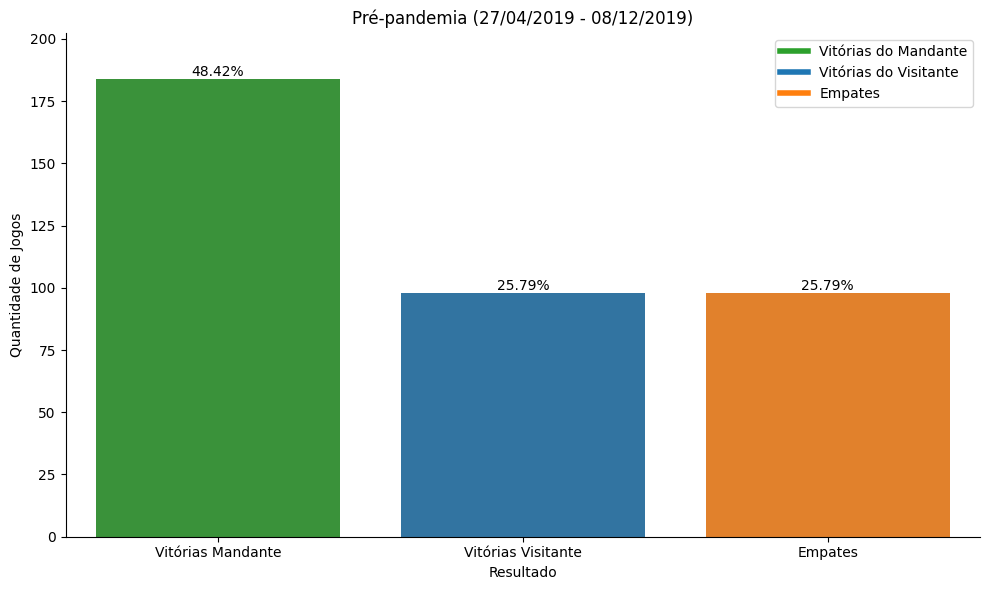

In [13]:
# Filtrar o DataFrame para 27/04/2019 - 08/12/2019
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['mandante']).count()
contagem_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']).count()
contagem_empates = df_periodo.filter(df_periodo['vencedor'] == '-').count()

# Dados para o gráfico
dados = {
    'Resultado': ['Vitórias Mandante', 'Vitórias Visitante', 'Empates'],
    'Quantidade': [contagem_mandante, contagem_visitante, contagem_empates]
}

# Converter dados em um DataFrame pandas
df_dados = pd.DataFrame(dados)

# Calcular as porcentagens
df_dados['Porcentagem'] = (df_dados['Quantidade'] / df_dados['Quantidade'].sum()) * 100

# Configurações estéticas
cor_vit_mandante = '#2ca02c'
cor_vit_visitante = '#1f77b4'
cor_empate = '#ff7f0e'

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Resultado', y='Quantidade', data=df_dados, palette=[cor_vit_mandante, cor_vit_visitante, cor_empate])
ax.yaxis.grid(False)
plt.ylabel('Quantidade de Jogos')
plt.title('Pré-pandemia (27/04/2019 - 08/12/2019)')

# Adicionar as porcentagens acima das barras
for i, value in enumerate(df_dados['Porcentagem']):
    plt.text(i, df_dados['Quantidade'][i], f'{value:.2f}%', ha='center', va='bottom')

# Remover bordas do gráfico
sns.despine()

# Ajustar limites do eixo y
plt.ylim(top=max(df_dados['Quantidade']) * 1.1)

# Adicionar legendas personalizadas
legend_labels = ['Vitórias do Mandante', 'Vitórias do Visitante', 'Empates']
custom_legend = [Line2D([0], [0], color=cor_vit_mandante, lw=4),
                 Line2D([0], [0], color=cor_vit_visitante, lw=4),
                 Line2D([0], [0], color=cor_empate, lw=4)]
plt.legend(custom_legend, legend_labels)

# Exibir o gráfico
plt.tight_layout()
plt.show()

Com base nos resultados, infere-se que, durante o período analisado, os jogos como mandante geralmente tiveram um desempenho melhor em termos de vitórias em comparação aos jogos como visitante. Isso sugere que a presença da torcida pode influenciar positivamente o desempenho e motivação da equipe mandante, proporcionando uma vantagem competitiva.

# **4. Brasileirão 2020 (Pandemia)**

In [14]:
# Filtrar o DataFrame para 08/08/2020 - 25/02/2021
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2020-08-08') & (df_campeonato['data'] <= '2021-02-25') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['mandante']).count()
contagem_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']).count()
contagem_empates = df_periodo.filter(df_periodo['vencedor'] == '-').count()

# Exibir os resultados
print("Número de vitórias do mandante: {}".format(contagem_mandante))
print("Número de vitórias do visitante: {}".format(contagem_visitante))
print("Número de empates: {}".format(contagem_empates))

if contagem_mandante > contagem_visitante:
    print("O mandante venceu mais jogos.")
elif contagem_visitante > contagem_mandante:
    print("O visitante venceu mais jogos.")
else:
    print("Houve o mesmo número de vitórias para mandante e visitante.")

print("Houve um total de {} jogos durante o período.".format(contagem_mandante + contagem_visitante + contagem_empates))


Número de vitórias do mandante: 171
Número de vitórias do visitante: 101
Número de empates: 108
O mandante venceu mais jogos.
Houve um total de 380 jogos durante o período.


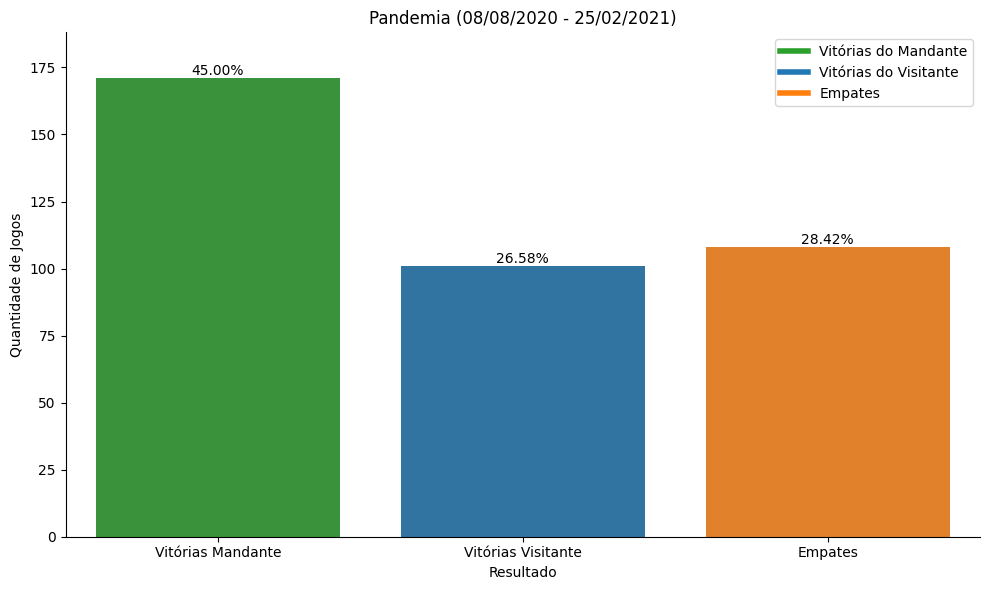

In [15]:
# Filtrar o DataFrame para 08/08/2020 - 25/02/2021
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2020-08-08') & (df_campeonato['data'] <= '2021-02-25') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['mandante']).count()
contagem_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']).count()
contagem_empates = df_periodo.filter(df_periodo['vencedor'] == '-').count()

# Dados para o gráfico
dados = {
    'Resultado': ['Vitórias Mandante', 'Vitórias Visitante', 'Empates'],
    'Quantidade': [contagem_mandante, contagem_visitante, contagem_empates]
}

# Converter dados em um DataFrame pandas
df_dados = pd.DataFrame(dados)

# Calcular as porcentagens
df_dados['Porcentagem'] = (df_dados['Quantidade'] / df_dados['Quantidade'].sum()) * 100

# Configurações estéticas
cor_vit_mandante = '#2ca02c'
cor_vit_visitante = '#1f77b4'
cor_empate = '#ff7f0e'

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Resultado', y='Quantidade', data=df_dados, palette=[cor_vit_mandante, cor_vit_visitante, cor_empate])
ax.yaxis.grid(False)
plt.ylabel('Quantidade de Jogos')
plt.title('Pandemia (08/08/2020 - 25/02/2021)')

# Adicionar as porcentagens acima das barras
for i, value in enumerate(df_dados['Porcentagem']):
    plt.text(i, df_dados['Quantidade'][i], f'{value:.2f}%', ha='center', va='bottom')

# Remover bordas do gráfico
sns.despine()

# Ajustar limites do eixo y
plt.ylim(top=max(df_dados['Quantidade']) * 1.1)

# Adicionar legendas personalizadas
legend_labels = ['Vitórias do Mandante', 'Vitórias do Visitante', 'Empates']
custom_legend = [Line2D([0], [0], color=cor_vit_mandante, lw=4),
                 Line2D([0], [0], color=cor_vit_visitante, lw=4),
                 Line2D([0], [0], color=cor_empate, lw=4)]
plt.legend(custom_legend, legend_labels)

# Exibir o gráfico
plt.tight_layout()
plt.show()

Com base nos resultados apresentados, infere-se que a ausência de público nos jogos teve um impacto relativamente pequeno nos resultados. Embora o número de vitórias do mandante ainda seja maior, a diferença em relação aos jogos com público é menor em comparação com o período anterior analisado (27/04/2019 - 08/12/2019). Isso sugere que outros fatores, como a qualidade das equipes, estratégias de jogo e habilidades individuais, podem ter desempenhado um papel mais significativo nos resultados.

# **5. Média entre os períodos**

In [16]:
# Filtrar o DataFrame para 27/04/2019 - 08/12/2019
df_periodo1 = df_campeonato.filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante1 = df_periodo1.filter(df_periodo1['vencedor'] == df_periodo1['mandante']).count()
contagem_visitante1 = df_periodo1.filter(df_periodo1['vencedor'] == df_periodo1['visitante']).count()
contagem_empates1 = df_periodo1.filter(df_periodo1['vencedor'] == '-').count()

# Exibir os resultados
print("Resultados do primeiro período (27/04/2019 - 08/12/2019):")
print("Número de vitórias do mandante: {}".format(contagem_mandante1))
print("Número de vitórias do visitante: {}".format(contagem_visitante1))
print("Número de empates: {}".format(contagem_empates1))
print("Total de jogos: {}".format(contagem_mandante1 + contagem_visitante1 + contagem_empates1))

Resultados do primeiro período (27/04/2019 - 08/12/2019):
Número de vitórias do mandante: 184
Número de vitórias do visitante: 98
Número de empates: 98
Total de jogos: 380


In [17]:
# Filtrar o DataFrame para 08/08/2020 - 25/02/2021
df_periodo2 = df_campeonato.filter(
    (df_campeonato['data'] >= '2020-08-08') & (df_campeonato['data'] <= '2021-02-25') & df_campeonato['vencedor'].isNotNull()
)

# Contar os jogos vencidos pelo mandante, pelo visitante e os empates
contagem_mandante2 = df_periodo2.filter(df_periodo2['vencedor'] == df_periodo2['mandante']).count()
contagem_visitante2 = df_periodo2.filter(df_periodo2['vencedor'] == df_periodo2['visitante']).count()
contagem_empates2 = df_periodo2.filter(df_periodo2['vencedor'] == '-').count()

# Exibir os resultados
print("Resultados do segundo período (08/08/2020 - 25/02/2021):")
print("Número de vitórias do mandante: {}".format(contagem_mandante2))
print("Número de vitórias do visitante: {}".format(contagem_visitante2))
print("Número de empates: {}".format(contagem_empates2))
print("Total de jogos: {}".format(contagem_mandante2 + contagem_visitante2 + contagem_empates2))


Resultados do segundo período (08/08/2020 - 25/02/2021):
Número de vitórias do mandante: 171
Número de vitórias do visitante: 101
Número de empates: 108
Total de jogos: 380


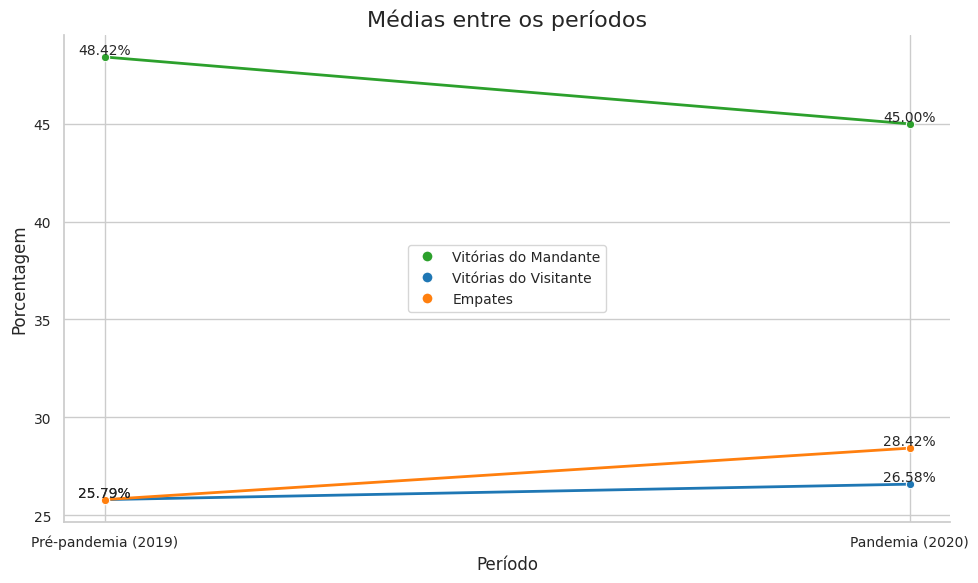

In [18]:
# Dados para o gráfico de linhas
periodos = ['Pré-pandemia (2019)', 'Pandemia (2020)']
categorias = ['Vitórias do Mandante', 'Vitórias do Visitante', 'Empates']

medias_mandante = [
    df_periodo1.filter(df_periodo1['vencedor'] == df_periodo1['mandante']).count() / df_periodo1.count() * 100,
    df_periodo2.filter(df_periodo2['vencedor'] == df_periodo2['mandante']).count() / df_periodo2.count() * 100
]

medias_visitante = [
    df_periodo1.filter(df_periodo1['vencedor'] == df_periodo1['visitante']).count() / df_periodo1.count() * 100,
    df_periodo2.filter(df_periodo2['vencedor'] == df_periodo2['visitante']).count() / df_periodo2.count() * 100
]

medias_empates = [
    df_periodo1.filter(df_periodo1['vencedor'] == '-').count() / df_periodo1.count() * 100,
    df_periodo2.filter(df_periodo2['vencedor'] == '-').count() / df_periodo2.count() * 100
]

# Configurações estéticas
sns.set(style="whitegrid")
cor_mandante = '#2ca02c'
cor_visitante = '#1f77b4'
cor_empates = '#ff7f0e'

# Plotar o gráfico de linhas
plt.figure(figsize=(10, 6))

# Definir estilos das linhas
sns.lineplot(x=periodos, y=medias_mandante, marker='o', color=cor_mandante, label='Vitórias do Mandante', linewidth=2)
sns.lineplot(x=periodos, y=medias_visitante, marker='o', color=cor_visitante, label='Vitórias do Visitante', linewidth=2)
sns.lineplot(x=periodos, y=medias_empates, marker='o', color=cor_empates, label='Empates', linewidth=2)

# Configurar o título e os rótulos dos eixos
plt.title('Médias entre os períodos', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Porcentagem', fontsize=12)

# Adicionar legenda personalizada
legend_labels = ['Vitórias do Mandante', 'Vitórias do Visitante', 'Empates']
custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_mandante, markersize=8),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_visitante, markersize=8),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_empates, markersize=8)]
plt.legend(custom_legend, legend_labels, fontsize=10, loc='center')

# Adicionar porcentagens
for i, periodo in enumerate(periodos):
    plt.text(periodo, medias_mandante[i], f'{medias_mandante[i]:.2f}%', ha='center', va='bottom', fontsize=10)
    plt.text(periodo, medias_visitante[i], f'{medias_visitante[i]:.2f}%', ha='center', va='bottom', fontsize=10)
    plt.text(periodo, medias_empates[i], f'{medias_empates[i]:.2f}%', ha='center', va='bottom', fontsize=10)

# Aumentar o tamanho dos tick labels dos eixos
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aumentar o tamanho da grade
sns.set_context("notebook", rc={"grid.linewidth": 1.5})

# Remover bordas do gráfico
sns.despine()

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico de linhas
plt.show()

Ao analisar o gráfico das médias de resultados, observo que, em média, as equipes mandantes tiveram um desempenho superior no período anterior à pandemia, com uma maior proporção de vitórias. Isso pode ser atribuído à presença do público nos estádios, que muitas vezes exerce influência e apoio aos times da casa.

Por outro lado, as vitórias do visitante apresentaram uma leve tendência de aumento durante a pandemia, embora essa diferença não seja estatisticamente significativa. Esse resultado pode indicar uma maior competitividade das equipes visitantes ou possíveis mudanças nas condições de jogo que favoreceram esse resultado.

Assim, ao comparar os dois períodos, nota-se que a ausência de público nos estádios durante a pandemia influenciou não apenas o desempenho das equipes mandantes e visitantes, mas também a ocorrência de empates. A média de empates apresentou um aumento um pouco maior do que a média de vitórias do visitante durante o período da pandemia. Essa mudança pode indicar uma maior igualdade de forças entre as equipes ou até mesmo o impacto da falta de torcida do time mandante, resultando em um número relativamente maior de empates nos jogos.

# **6. Desvio Padrão entre os períodos**

In [19]:
# Dados para o cálculo do desvio padrão
dados_desvio = {
    'Período': ['1º Período', '2º Período'],
    'Vitórias do Mandante': [contagem_mandante1, contagem_mandante2],
    'Vitórias do Visitante': [contagem_visitante1, contagem_visitante2],
    'Empates': [contagem_empates1, contagem_empates2]
}

# Criar DataFrame
df_dados_desvio = pd.DataFrame(dados_desvio)

# Calcular o desvio padrão entre os períodos
desvios = df_dados_desvio.std(numeric_only=True)

# Exibir o resultado
print("Desvio Padrão entre os Períodos:")
print(desvios)

Desvio Padrão entre os Períodos:
Vitórias do Mandante     9.192388
Vitórias do Visitante    2.121320
Empates                  7.071068
dtype: float64


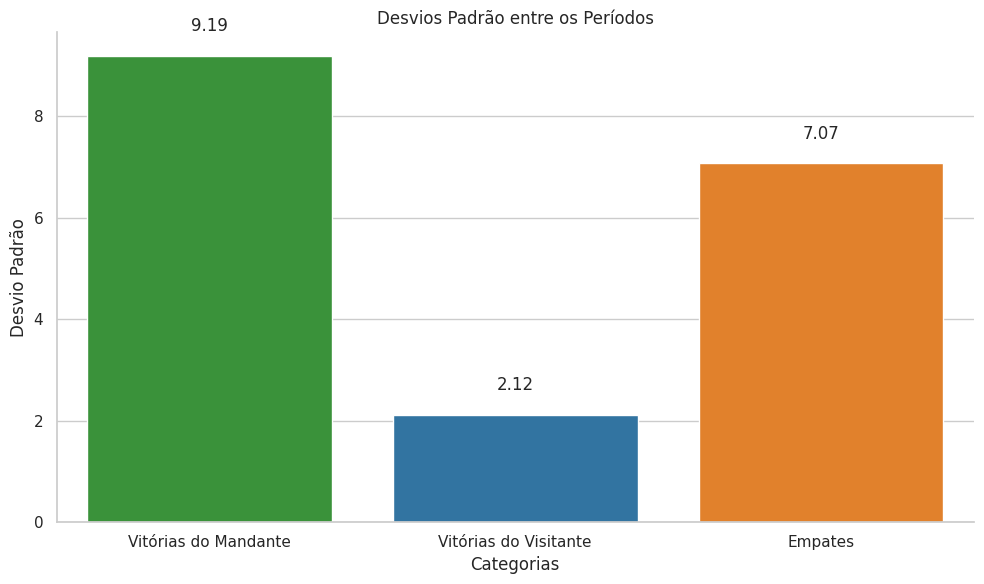

In [20]:
# Dados para o gráfico de barras
periodos = ['1º Período', '2º Período']
categorias = ['Vitórias do Mandante', 'Vitórias do Visitante', 'Empates']
desvios = [9.192388, 2.121320, 7.071068]

# Configurações estéticas
sns.set(style="whitegrid")
cores = ['#2ca02c', '#1f77b4', '#ff7f0e']

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=categorias, y=desvios, palette=cores)

# Adicionar rótulos para cada ponto no gráfico
for i, desvio in enumerate(desvios):
    plt.text(i, desvio + 0.4, str(round(desvio, 2)), ha='center', va='bottom')

# Configurar o título e os rótulos dos eixos
plt.title('Desvios Padrão entre os Períodos')
plt.xlabel('Categorias')
plt.ylabel('Desvio Padrão')

# Remover bordas do gráfico
sns.despine()

# Exibir o gráfico
plt.tight_layout()
plt.show()

# Com base nos resultados do desvio padrão entre os períodos, infere-se o seguinte:

**Vitórias do Mandante:** O desvio padrão entre os períodos é de aproximadamente 9.192388. Isso indica que houve uma variação significativa na quantidade de vitórias do mandante entre os dois períodos. A dispersão dos dados em relação à média é maior nessa categoria.

**Vitórias do Visitante:** O desvio padrão entre os períodos é de aproximadamente 2.121320. Isso indica que houve uma variação menor na quantidade de vitórias do visitante entre os dois períodos em comparação com as vitórias do mandante. A dispersão dos dados em relação à média é menor nessa categoria.

**Empates:** O desvio padrão entre os períodos é de aproximadamente 7.071068. Isso indica que houve uma variação considerável na quantidade de empates entre os dois períodos. A dispersão dos dados em relação à média é maior nessa categoria.

Em resumo, o desvio padrão nos fornece uma medida de dispersão dos dados em relação à média. Quanto maior o desvio padrão, maior é a dispersão dos dados e maior é a variabilidade dos resultados. Por outro lado, um desvio padrão menor indica menor variabilidade e maior consistência nos resultados.


# **7. Gols 2019 (Pré-Pandemia)**

In [21]:
# Filtrar o DataFrame para o período 27/04/2019 - 08/12/2019
df_periodo1 = df_campeonato.filter(
    (df_campeonato['Data'] >= '2019-04-27') & (df_campeonato['Data'] <= '2019-12-08')
)

# Calcular o somatório dos gols dos mandantes no período 27/04/2019 - 08/12/2019
total_gols_mandantes_periodo1 = df_periodo1.select(sum('mandante_Placar')).collect()[0][0]

# Calcular o somatório dos gols dos visitantes no período 27/04/2019 - 08/12/2019
total_gols_visitantes_periodo1 = df_periodo1.select(sum('visitante_Placar')).collect()[0][0]

# Calcular o somatório geral de gols no período 27/04/2019 - 08/12/2019
total_gols_geral_periodo1 = total_gols_mandantes_periodo1 + total_gols_visitantes_periodo1

# Calcular a média de gols dos mandantes no período 27/04/2019 - 08/12/2019
media_gols_mandantes_periodo1 = df_periodo1.select(avg('mandante_Placar')).collect()[0][0]

# Calcular a média de gols dos visitantes no período 27/04/2019 - 08/12/2019
media_gols_visitantes_periodo1 = df_periodo1.select(avg('visitante_Placar')).collect()[0][0]

# Calcular a média geral de gols no período 27/04/2019 - 08/12/2019
media_gols_periodo1 = df_periodo1.select(avg('mandante_Placar') + avg('visitante_Placar')).collect()[0][0]

# Exibir os resultados
print("Estatísticas do período 27/04/2019 - 08/12/2019 (Pré-pandemia):")
print("Total de gols dos mandantes:", total_gols_mandantes_periodo1)
print("Total de gols dos visitantes:", total_gols_visitantes_periodo1)
print("Total geral de gols:", total_gols_geral_periodo1)
print("Média de gols dos mandantes:", media_gols_mandantes_periodo1)
print("Média de gols dos visitantes:", media_gols_visitantes_periodo1)
print("Média geral de gols:", media_gols_periodo1)

Estatísticas do período 27/04/2019 - 08/12/2019 (Pré-pandemia):
Total de gols dos mandantes: 525
Total de gols dos visitantes: 351
Total geral de gols: 876
Média de gols dos mandantes: 1.381578947368421
Média de gols dos visitantes: 0.9236842105263158
Média geral de gols: 2.305263157894737


# **8. Gols 2020 (Pandemia)**

In [22]:
# Filtrar o DataFrame para o período 08/08/2020 - 25/02/2021
df_periodo2 = df_campeonato.filter(
    (df_campeonato['Data'] >= '2020-08-08') & (df_campeonato['Data'] <= '2021-02-25')
)

# Calcular o somatório dos gols dos mandantes no período 08/08/2020 - 25/02/2021
total_gols_mandantes_periodo2 = df_periodo2.select(sum('mandante_Placar')).collect()[0][0]

# Calcular o somatório dos gols dos visitantes no período 08/08/2020 - 25/02/2021
total_gols_visitantes_periodo2 = df_periodo2.select(sum('visitante_Placar')).collect()[0][0]

# Calcular o somatório geral de gols no período 08/08/2020 - 25/02/2021
total_gols_geral_periodo2 = total_gols_mandantes_periodo2 + total_gols_visitantes_periodo2

# Calcular a média de gols dos mandantes no período 08/08/2020 - 25/02/2021
media_gols_mandantes_periodo2 = df_periodo2.select(avg('mandante_Placar')).collect()[0][0]

# Calcular a média de gols dos visitantes no período 08/08/2020 - 25/02/2021
media_gols_visitantes_periodo2 = df_periodo2.select(avg('visitante_Placar')).collect()[0][0]

# Calcular a média geral de gols no período 08/08/2020 - 25/02/2021
media_gols_periodo2 = df_periodo2.select(avg('mandante_Placar') + avg('visitante_Placar')).collect()[0][0]

# Exibir os resultados
print("Estatísticas do período 08/08/2020 - 25/02/2021 (Pandemia):")
print("Total de gols dos mandantes:", total_gols_mandantes_periodo2)
print("Total de gols dos visitantes:", total_gols_visitantes_periodo2)
print("Total geral de gols:", total_gols_geral_periodo2)
print("Média de gols dos mandantes:", media_gols_mandantes_periodo2)
print("Média de gols dos visitantes:", media_gols_visitantes_periodo2)
print("Média geral de gols:", media_gols_periodo2)

Estatísticas do período 08/08/2020 - 25/02/2021 (Pandemia):
Total de gols dos mandantes: 536
Total de gols dos visitantes: 408
Total geral de gols: 944
Média de gols dos mandantes: 1.4105263157894736
Média de gols dos visitantes: 1.0736842105263158
Média geral de gols: 2.484210526315789


# **9. Comparação de gols entre os períodos**

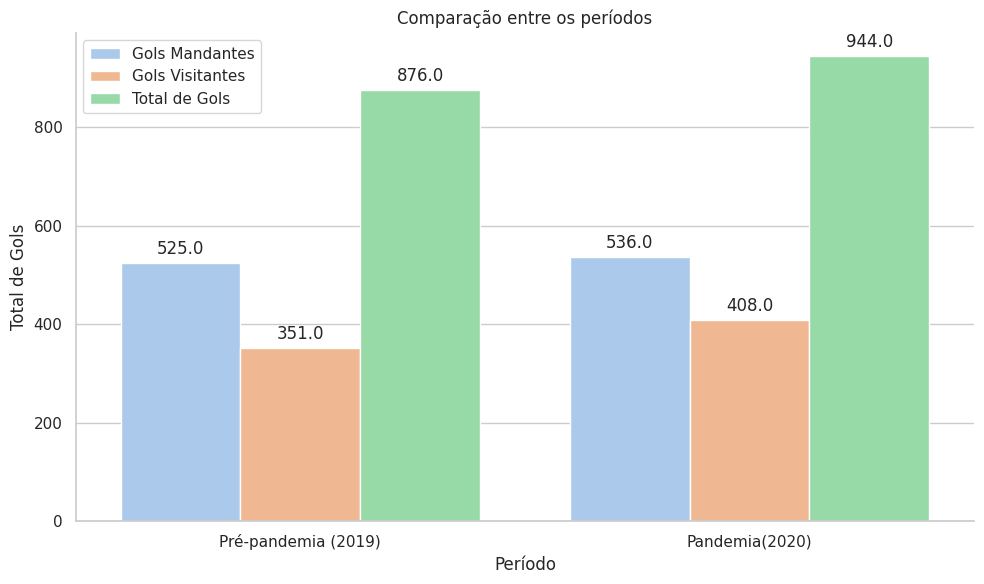

In [33]:
# Dados para o gráfico
periodos = ['Pré-pandemia (2019)', 'Pandemia(2020)']
gols_mandantes = [total_gols_mandantes_periodo1, total_gols_mandantes_periodo2]
gols_visitantes = [total_gols_visitantes_periodo1, total_gols_visitantes_periodo2]
gols_geral = [total_gols_geral_periodo1, total_gols_geral_periodo2]

# Criar DataFrame
dados = {
    'Período': periodos,
    'Gols dos Mandantes': gols_mandantes,
    'Gols dos Visitantes': gols_visitantes,
    'Total Geral de Gols': gols_geral
}
df_dados = pd.DataFrame(dados)

# Configurações estéticas
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Plotar o gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Período", y="value", hue="variable", data=pd.melt(df_dados, ['Período']), errorbar=None)

# Adicionar rótulos nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Configurar o título e os rótulos dos eixos
plt.title('Comparação entre os períodos')
plt.xlabel('Período')
plt.ylabel('Total de Gols')

# Adicionar legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Gols Mandantes', 'Gols Visitantes', 'Total de Gols'])

# Remover bordas do gráfico
sns.despine()

# Exibir o gráfico
plt.tight_layout()
plt.show()

Durante a pandemia, houve um aumento no total de gols marcados tanto pelos mandantes quanto pelos visitantes, e uma média geral de gols mais alta. Os visitantes marcaram um total de 408 gols, em comparação com 351 gols no período pré-pandemia. Isso mostra um aumento significativo no desempenho dos visitantes em marcar gols durante a pandemia e isso pode estar relacionado a diversos fatores, incluindo a ausência de torcida nos estádios ou adaptação das equipes às novas circunstâncias impostas pela pandemia.

# **10. Médias de gols entre os períodos**

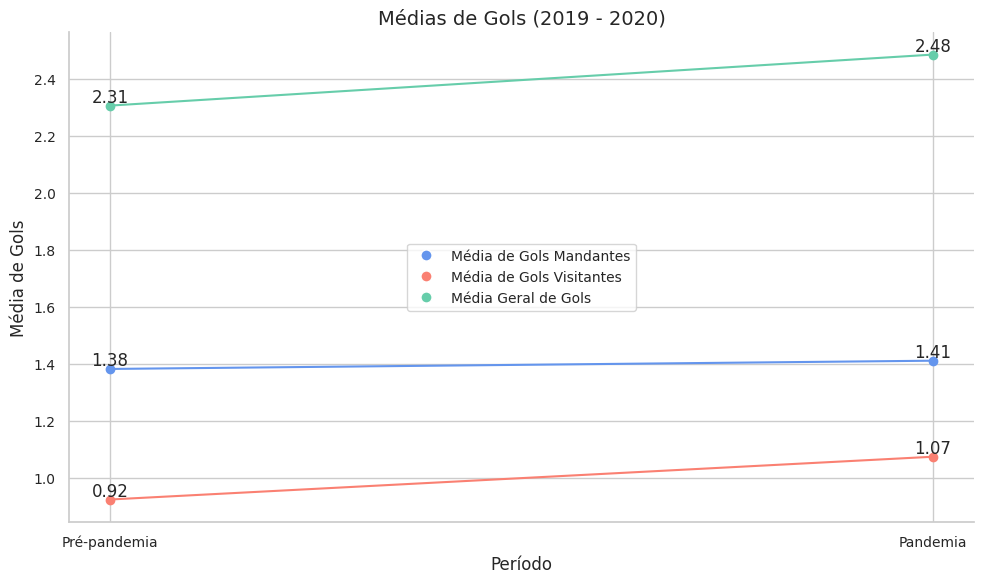

In [34]:
# Médias de gols de mandantes e visitantes de 2019 e 2020
medias_mandantes = [media_gols_mandantes_periodo1, media_gols_mandantes_periodo2]
medias_visitantes = [media_gols_visitantes_periodo1, media_gols_visitantes_periodo2]
medias_gerais = [media_gols_periodo1, media_gols_periodo2]

# Anos para o eixo x
anos = ['Pré-pandemia', 'Pandemia']

# Configurações estéticas
cor_mandantes = '#6495ED'
cor_visitantes = '#FA8072'
cor_geral = '#66CDAA'

# Plotar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(anos, medias_mandantes, marker='o', color=cor_mandantes, label='Média de Gols Mandantes')
plt.plot(anos, medias_visitantes, marker='o', color=cor_visitantes, label='Média de Gols Visitantes')
plt.plot(anos, medias_gerais, marker='o', color=cor_geral, label='Média Geral de Gols')

# Adicionar rótulos aos pontos
for x, y1, y2, y3 in zip(anos, medias_mandantes, medias_visitantes, medias_gerais):
    plt.text(x, y1, f'{y1:.2f}', ha='center', va='bottom')
    plt.text(x, y2, f'{y2:.2f}', ha='center', va='bottom')
    plt.text(x, y3, f'{y3:.2f}', ha='center', va='bottom')

# Adicionar legenda personalizada
legend_labels = ['Média de Gols Mandantes', 'Média de Gols Visitantes', 'Média Geral de Gols']
custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_mandantes, markersize=8),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_visitantes, markersize=8),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor=cor_geral, markersize=8)]
plt.legend(custom_legend, legend_labels, fontsize=10, loc='center')

# Configurar rótulos dos eixos
plt.xlabel('Período', fontsize=12)
plt.ylabel('Média de Gols', fontsize=12)

# Configurar título do gráfico
plt.title('Médias de Gols (2019 - 2020)', fontsize=14)

# Configurar tamanho dos tick labels dos eixos
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aumentar o tamanho da grade
sns.set_context("notebook", rc={"grid.linewidth": 1.5})

# Remover bordas do gráfico
sns.despine()

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

A média geral de gols durante a pandemia foi de 2.48, em comparação com 2.31 no período pré-pandemia. Esse aumento na média geral de gols reflete a tendência de partidas mais ofensivas durante a pandemia.



# **11. Desempenho individual dos clubes**

Brasileirão 2019

In [25]:
# Filtrar o DataFrame para o período de 27/04/2019 a 08/12/2019
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08')
)

# Contagem de vitórias para cada clube como visitante
contagem_vitorias_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']) \
    .groupBy('visitante') \
    .agg(sum(when(df_periodo['vencedor'] == df_periodo['visitante'], 1)).alias('Vitórias Visitante'))

# Contagem de derrotas para cada clube como mandante
contagem_derrotas_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']) \
    .groupBy('mandante') \
    .agg(sum(when(df_periodo['vencedor'] != df_periodo['mandante'], 1)).alias('Derrotas Mandante'))

# Combinar as contagens de vitórias e derrotas
contagem_total = contagem_vitorias_visitante \
    .join(contagem_derrotas_mandante, contagem_vitorias_visitante['visitante'] == contagem_derrotas_mandante['mandante'], 'outer') \
    .fillna(0) \
    .select(contagem_vitorias_visitante['visitante'].alias('Clube'),
            col('Vitórias Visitante').alias('Vitórias como Visitante'),
            col('Derrotas Mandante').alias('Derrotas como Mandante')) \
    .withColumn('Vitórias como Visitante', col('Vitórias como Visitante').cast(IntegerType())) \
    .withColumn('Derrotas como Mandante', col('Derrotas como Mandante').cast(IntegerType()))

# Exibir a tabela com o número de vitórias como visitante e derrotas como mandante de cada clube
contagem_total = contagem_total.orderBy(col('Vitórias como Visitante').desc())
contagem_total.show()

+-------------+-----------------------+----------------------+
|        Clube|Vitórias como Visitante|Derrotas como Mandante|
+-------------+-----------------------+----------------------+
|     Flamengo|                     11|                     0|
|    Palmeiras|                      8|                     2|
|       Santos|                      8|                     1|
|       Gremio|                      7|                     4|
|    Sao Paulo|                      7|                     3|
| Athletico-PR|                      6|                     4|
|   Fluminense|                      6|                     6|
|        Bahia|                      5|                     4|
|Internacional|                      5|                     2|
|        Vasco|                      5|                     6|
|  Botafogo-RJ|                      4|                     8|
|  Corinthians|                      4|                     2|
|    Fortaleza|                      4|                

Brasileirão 2020

In [26]:
# Filtrar o DataFrame para o período de 08/08/2020 - 25/02/2021
df_periodo = df_campeonato.filter(
    (df_campeonato['data'] >= '2020-08-08') & (df_campeonato['data'] <= '2021-02-25')
)

# Contagem de vitórias para cada clube como visitante
contagem_vitorias_visitante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']) \
    .groupBy('visitante') \
    .agg(sum(when(df_periodo['vencedor'] == df_periodo['visitante'], 1)).alias('Vitórias Visitante'))

# Contagem de derrotas para cada clube como mandante
contagem_derrotas_mandante = df_periodo.filter(df_periodo['vencedor'] == df_periodo['visitante']) \
    .groupBy('mandante') \
    .agg(sum(when(df_periodo['vencedor'] != df_periodo['mandante'], 1)).alias('Derrotas Mandante'))

# Combinar as contagens de vitórias e derrotas
contagem_total = contagem_vitorias_visitante \
    .join(contagem_derrotas_mandante, contagem_vitorias_visitante['visitante'] == contagem_derrotas_mandante['mandante'], 'outer') \
    .fillna(0) \
    .select(contagem_vitorias_visitante['visitante'].alias('Clube'),
            col('Vitórias Visitante').alias('Vitórias como Visitante'),
            col('Derrotas Mandante').alias('Derrotas como Mandante')) \
    .withColumn('Vitórias como Visitante', col('Vitórias como Visitante').cast(IntegerType())) \
    .withColumn('Derrotas como Mandante', col('Derrotas como Mandante').cast(IntegerType()))

# Exibir a tabela com o número de vitórias como visitante e derrotas como mandante de cada clube
contagem_total = contagem_total.orderBy(col('Vitórias como Visitante').desc())
contagem_total.show()

+-------------+-----------------------+----------------------+
|        Clube|Vitórias como Visitante|Derrotas como Mandante|
+-------------+-----------------------+----------------------+
|     Flamengo|                     10|                     4|
|Internacional|                      8|                     2|
|    Sao Paulo|                      8|                     2|
|        Ceara|                      7|                     7|
|   Fluminense|                      7|                     3|
| Athletico-PR|                      6|                     5|
|  Atletico-GO|                      6|                     4|
|  Atletico-MG|                      6|                     1|
|    Palmeiras|                      6|                     2|
|  Corinthians|                      5|                     4|
|       Santos|                      5|                     3|
|       Gremio|                      4|                     3|
|        Sport|                      4|                

# **12. Vitória como Visitante e Derrota como Mandante 2019 (Pré-pandemia)**

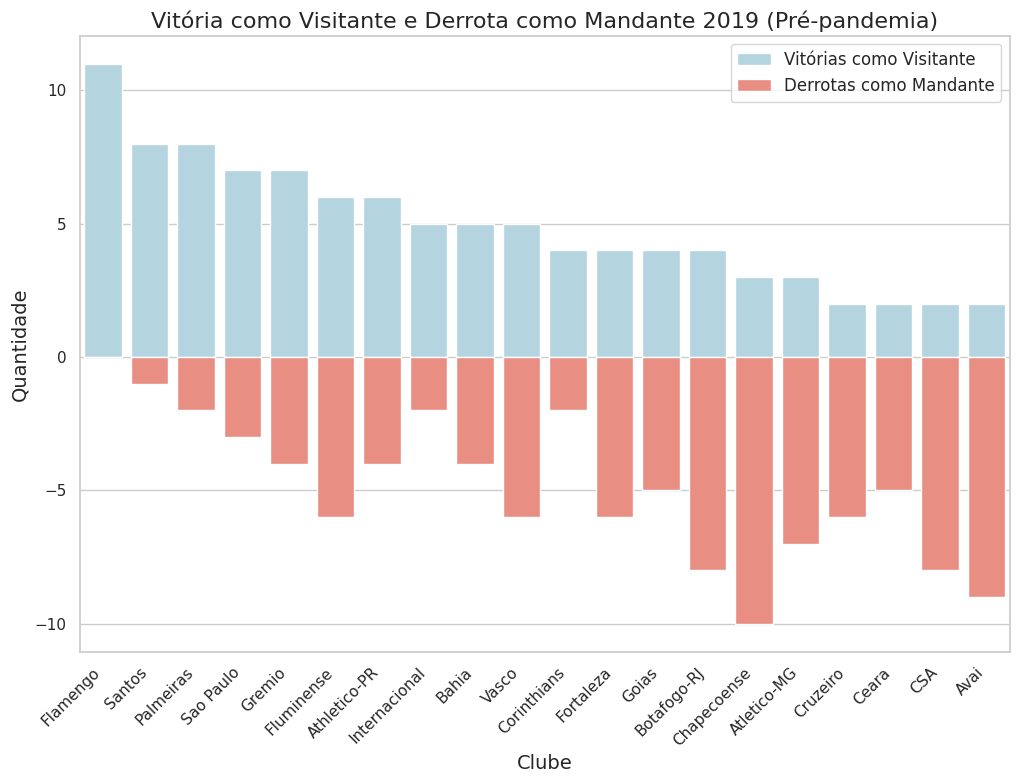

In [27]:
# Filtrar o DataFrame para o período de 27/04/2019 - 08/12/2019
df_periodo_pandemia = df_campeonato.filter(
    (df_campeonato['data'] >= '2019-04-27') & (df_campeonato['data'] <= '2019-12-08')
)

# Contagem de vitórias para cada clube como visitante na pandemia
contagem_vitorias_visitante_pandemia = df_periodo_pandemia.filter(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante']) \
    .groupBy('visitante') \
    .agg(sum(when(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante'], 1)).alias('Vitórias Visitante'))

# Contagem de derrotas para cada clube como mandante na pandemia
contagem_derrotas_mandante_pandemia = df_periodo_pandemia.filter(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante']) \
    .groupBy('mandante') \
    .agg(sum(when(df_periodo_pandemia['vencedor'] != df_periodo_pandemia['mandante'], 1)).alias('Derrotas Mandante'))

# Combinar as contagens de vitórias e derrotas na pandemia
contagem_total_pandemia = contagem_vitorias_visitante_pandemia \
    .join(contagem_derrotas_mandante_pandemia, contagem_vitorias_visitante_pandemia['visitante'] == contagem_derrotas_mandante_pandemia['mandante'], 'outer') \
    .fillna(0) \
    .select(contagem_vitorias_visitante_pandemia['visitante'].alias('Clube'),
            col('Vitórias Visitante').alias('Vitórias como Visitante'),
            col('Derrotas Mandante').alias('Derrotas como Mandante')) \
    .withColumn('Vitórias como Visitante', col('Vitórias como Visitante').cast(IntegerType())) \
    .withColumn('Derrotas como Mandante', col('Derrotas como Mandante').cast(IntegerType()))

# Configurar os dados para o gráfico
data_pandemia = contagem_total_pandemia.toPandas()
data_pandemia = data_pandemia.sort_values(by='Vitórias como Visitante', ascending=False)
clubes_pandemia = data_pandemia['Clube']
vitorias_visitante_pandemia = data_pandemia['Vitórias como Visitante']
derrotas_mandante_pandemia = data_pandemia['Derrotas como Mandante']

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Configurar as barras do gráfico
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=clubes_pandemia, y=vitorias_visitante_pandemia, color='lightblue', label='Vitórias como Visitante', ax=ax)
sns.barplot(x=clubes_pandemia, y=-derrotas_mandante_pandemia, color='salmon', label='Derrotas como Mandante', ax=ax)

# Configurar o título e os rótulos dos eixos
ax.set_title('Vitória como Visitante e Derrota como Mandante 2019 (Pré-pandemia)', fontsize=16)
ax.set_xlabel('Clube', fontsize=14)
ax.set_ylabel('Quantidade', fontsize=14)

# Configurar a legenda
ax.legend(loc='upper right', fontsize=12)

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.show()

# **13. Vitória como Visitante e Derrota como Mandante 2020 (Pandemia)**

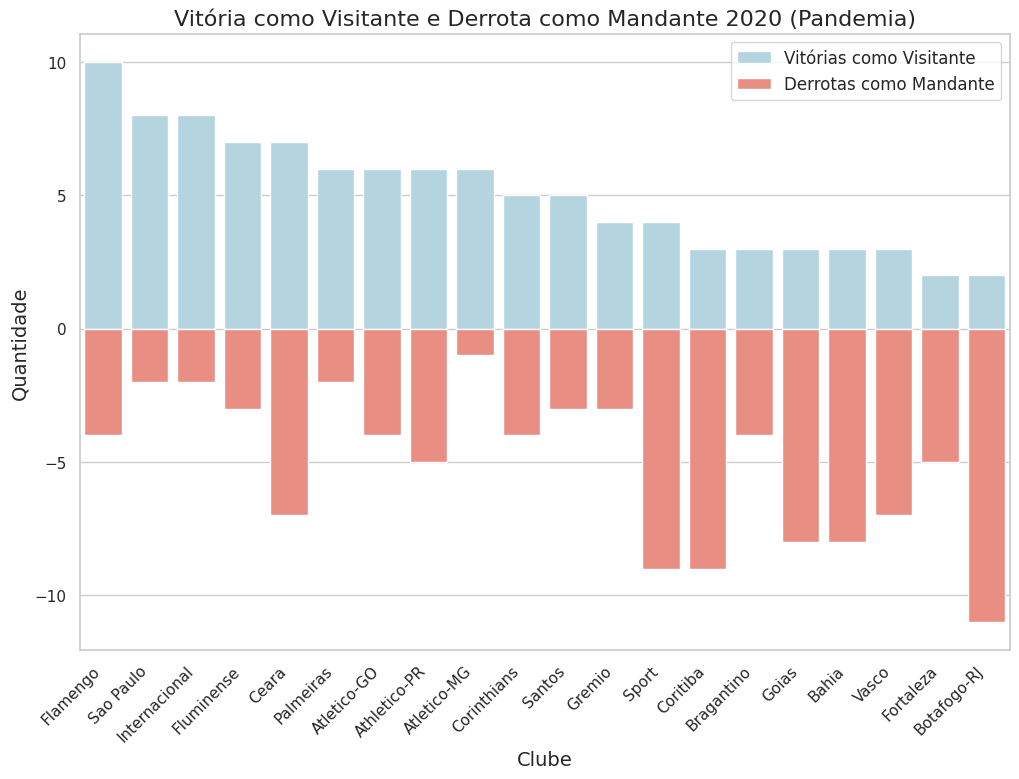

In [28]:
# Filtrar o DataFrame para o período de 08/08/2020 - 25/02/2021
df_periodo_pandemia = df_campeonato.filter(
    (df_campeonato['data'] >= '2020-08-08') & (df_campeonato['data'] <= '2021-02-25')
)

# Contagem de vitórias para cada clube como visitante na pandemia
contagem_vitorias_visitante_pandemia = df_periodo_pandemia.filter(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante']) \
    .groupBy('visitante') \
    .agg(sum(when(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante'], 1)).alias('Vitórias Visitante'))

# Contagem de derrotas para cada clube como mandante na pandemia
contagem_derrotas_mandante_pandemia = df_periodo_pandemia.filter(df_periodo_pandemia['vencedor'] == df_periodo_pandemia['visitante']) \
    .groupBy('mandante') \
    .agg(sum(when(df_periodo_pandemia['vencedor'] != df_periodo_pandemia['mandante'], 1)).alias('Derrotas Mandante'))

# Combinar as contagens de vitórias e derrotas na pandemia
contagem_total_pandemia = contagem_vitorias_visitante_pandemia \
    .join(contagem_derrotas_mandante_pandemia, contagem_vitorias_visitante_pandemia['visitante'] == contagem_derrotas_mandante_pandemia['mandante'], 'outer') \
    .fillna(0) \
    .select(contagem_vitorias_visitante_pandemia['visitante'].alias('Clube'),
            col('Vitórias Visitante').alias('Vitórias como Visitante'),
            col('Derrotas Mandante').alias('Derrotas como Mandante')) \
    .withColumn('Vitórias como Visitante', col('Vitórias como Visitante').cast(IntegerType())) \
    .withColumn('Derrotas como Mandante', col('Derrotas como Mandante').cast(IntegerType()))

# Configurar os dados para o gráfico
data_pandemia = contagem_total_pandemia.toPandas()
data_pandemia = data_pandemia.sort_values(by='Vitórias como Visitante', ascending=False)
clubes_pandemia = data_pandemia['Clube']
vitorias_visitante_pandemia = data_pandemia['Vitórias como Visitante']
derrotas_mandante_pandemia = data_pandemia['Derrotas como Mandante']

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Configurar as barras do gráfico
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=clubes_pandemia, y=vitorias_visitante_pandemia, color='lightblue', label='Vitórias como Visitante', ax=ax)
sns.barplot(x=clubes_pandemia, y=-derrotas_mandante_pandemia, color='salmon', label='Derrotas como Mandante', ax=ax)

# Configurar o título e os rótulos dos eixos
ax.set_title('Vitória como Visitante e Derrota como Mandante 2020 (Pandemia)', fontsize=16)
ax.set_xlabel('Clube', fontsize=14)
ax.set_ylabel('Quantidade', fontsize=14)

# Configurar a legenda
ax.legend(loc='upper right', fontsize=12)

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.show()

# **14. Tabelas das categorias**

In [29]:
# Dados para o período de pré-pandemia
data_pre_pandemia = [
    ("Flamengo", 11, 0, "Pré-pandemia"),
    ("Palmeiras", 8, 2, "Pré-pandemia"),
    ("Santos", 8, 1, "Pré-pandemia"),
    ("Gremio", 7, 4, "Pré-pandemia"),
    ("Sao Paulo", 7, 3, "Pré-pandemia"),
    ("Athletico-PR", 6, 4, "Pré-pandemia"),
    ("Fluminense", 6, 6, "Pré-pandemia"),
    ("Bahia", 5, 4, "Pré-pandemia"),
    ("Internacional", 5, 2, "Pré-pandemia"),
    ("Vasco", 5, 6, "Pré-pandemia"),
    ("Botafogo-RJ", 4, 8, "Pré-pandemia"),
    ("Corinthians", 4, 2, "Pré-pandemia"),
    ("Fortaleza", 4, 6, "Pré-pandemia"),
    ("Goias", 4, 5, "Pré-pandemia"),
    ("Atletico-MG", 3, 7, "Pré-pandemia"),
    ("Chapecoense", 3, 10, "Pré-pandemia"),
    ("Avai", 2, 9, "Pré-pandemia"),
    ("CSA", 2, 8, "Pré-pandemia"),
    ("Ceara", 2, 5, "Pré-pandemia"),
    ("Cruzeiro", 2, 6, "Pré-pandemia")
]

# Dados para o período de pandemia
data_pandemia = [
    ("Flamengo", 10, 4, "Pandemia"),
    ("Internacional", 8, 2, "Pandemia"),
    ("Sao Paulo", 8, 2, "Pandemia"),
    ("Ceara", 7, 7, "Pandemia"),
    ("Fluminense", 7, 3, "Pandemia"),
    ("Athletico-PR", 6, 5, "Pandemia"),
    ("Atletico-GO", 6, 4, "Pandemia"),
    ("Atletico-MG", 6, 1, "Pandemia"),
    ("Palmeiras", 6, 2, "Pandemia"),
    ("Corinthians", 5, 4, "Pandemia"),
    ("Santos", 5, 3, "Pandemia"),
    ("Gremio", 4, 3, "Pandemia"),
    ("Sport", 4, 9, "Pandemia"),
    ("Bahia", 3, 8, "Pandemia"),
    ("Bragantino", 3, 4, "Pandemia"),
    ("Coritiba", 3, 9, "Pandemia"),
    ("Goias", 3, 8, "Pandemia"),
    ("Vasco", 3, 7, "Pandemia"),
    ("Botafogo-RJ", 2, 11, "Pandemia"),
    ("Fortaleza", 2, 5, "Pandemia")
]

# Criar DataFrames a partir dos dados
columns = ['Clube', 'Vitórias como Visitante', 'Derrotas como Mandante', 'Período']
df_pre_pandemia = spark.createDataFrame(data_pre_pandemia, columns)
df_pandemia = spark.createDataFrame(data_pandemia, columns)

# Função para calcular as estatísticas de vitórias como visitante e derrotas como mandante
def calcular_estatisticas(df_periodo):
    # Contagem de vitórias para cada clube como visitante
    contagem_vitorias_visitante = df_periodo.groupBy('Clube').agg(sum('Vitórias como Visitante').alias('Vitórias como Visitante'))

    # Contagem de derrotas para cada clube como mandante
    contagem_derrotas_mandante = df_periodo.groupBy('Clube').agg(sum('Derrotas como Mandante').alias('Derrotas como Mandante'))

    # Combinar as contagens de vitórias e derrotas
    contagem_total = contagem_vitorias_visitante.join(contagem_derrotas_mandante, ['Clube'], 'inner').fillna(0)

    return contagem_total

# Calcular estatísticas para o período de pré-pandemia
contagem_total_pre = calcular_estatisticas(df_pre_pandemia)

# Calcular estatísticas para o período de pandemia
contagem_total_pandemia = calcular_estatisticas(df_pandemia)

# Exibir a tabela com o número de vitórias como visitante e derrotas como mandante de cada clube para ambos os períodos
contagem_total_pre.show()
contagem_total_pandemia.show()

+-------------+-----------------------+----------------------+
|        Clube|Vitórias como Visitante|Derrotas como Mandante|
+-------------+-----------------------+----------------------+
|       Santos|                      8|                     1|
|     Flamengo|                     11|                     0|
|        Vasco|                      5|                     6|
|Internacional|                      5|                     2|
|   Fluminense|                      6|                     6|
|    Palmeiras|                      8|                     2|
|        Bahia|                      5|                     4|
|    Sao Paulo|                      7|                     3|
|       Gremio|                      7|                     4|
| Athletico-PR|                      6|                     4|
|         Avai|                      2|                     9|
|    Fortaleza|                      4|                     6|
|     Cruzeiro|                      2|                

# **15. Clubes que mais variaram entre as categorias**

In [30]:
# Função para calcular as estatísticas de vitórias como visitante e derrotas como mandante
def calcular_estatisticas(df_periodo):
    # Contagem de vitórias para cada clube como visitante
    contagem_vitorias_visitante = df_periodo.groupBy('Clube').agg(sum('Vitórias como Visitante').alias('Vitórias como Visitante'))

    # Contagem de derrotas para cada clube como mandante
    contagem_derrotas_mandante = df_periodo.groupBy('Clube').agg(sum('Derrotas como Mandante').alias('Derrotas como Mandante'))

    # Combinar as contagens de vitórias e derrotas
    contagem_total = contagem_vitorias_visitante.join(contagem_derrotas_mandante, ['Clube'], 'inner').fillna(0)

    return contagem_total

# Calcular estatísticas para o período de pré-pandemia
contagem_total_pre = calcular_estatisticas(df_pre_pandemia)

# Calcular estatísticas para o período de pandemia
contagem_total_pandemia = calcular_estatisticas(df_pandemia)

# Calcular a variação de vitórias como visitante entre os períodos
variacoes_vitorias_visitante = contagem_total_pandemia.join(contagem_total_pre, ['Clube'], 'inner') \
    .withColumn('Variação de Vitórias como Visitante', contagem_total_pandemia['Vitórias como Visitante'] - contagem_total_pre['Vitórias como Visitante']) \
    .orderBy(col('Variação de Vitórias como Visitante').desc()) \
    .select('Clube', contagem_total_pre['Vitórias como Visitante'].alias('Vitórias como Visitante_Pre'), contagem_total_pandemia['Vitórias como Visitante'], 'Variação de Vitórias como Visitante') \
    .limit(3)

# Calcular a variação de derrotas como mandante entre os períodos
variacoes_derrotas_mandante = contagem_total_pandemia.join(contagem_total_pre, ['Clube'], 'inner') \
    .withColumn('Variação de Derrotas como Mandante', contagem_total_pandemia['Derrotas como Mandante'] - contagem_total_pre['Derrotas como Mandante']) \
    .orderBy(col('Variação de Derrotas como Mandante').desc()) \
    .select('Clube', contagem_total_pre['Derrotas como Mandante'].alias('Derrotas como Mandante_Pre'), contagem_total_pandemia['Derrotas como Mandante'], 'Variação de Derrotas como Mandante') \
    .limit(3)

# Exibir os resultados
print("Três primeiros clubes com maior variação de vitórias como visitante:")
variacoes_vitorias_visitante.show()

print("Três primeiros clubes com maior variação de derrotas como mandante:")
variacoes_derrotas_mandante.show()

Três primeiros clubes com maior variação de vitórias como visitante:
+-------------+---------------------------+-----------------------+-----------------------------------+
|        Clube|Vitórias como Visitante_Pre|Vitórias como Visitante|Variação de Vitórias como Visitante|
+-------------+---------------------------+-----------------------+-----------------------------------+
|        Ceara|                          2|                      7|                                  5|
|  Atletico-MG|                          3|                      6|                                  3|
|Internacional|                          5|                      8|                                  3|
+-------------+---------------------------+-----------------------+-----------------------------------+

Três primeiros clubes com maior variação de derrotas como mandante:
+-----------+--------------------------+----------------------+----------------------------------+
|      Clube|Derrotas como Mandante

# **16. Clubes que mais variaram na vitória como visitante**

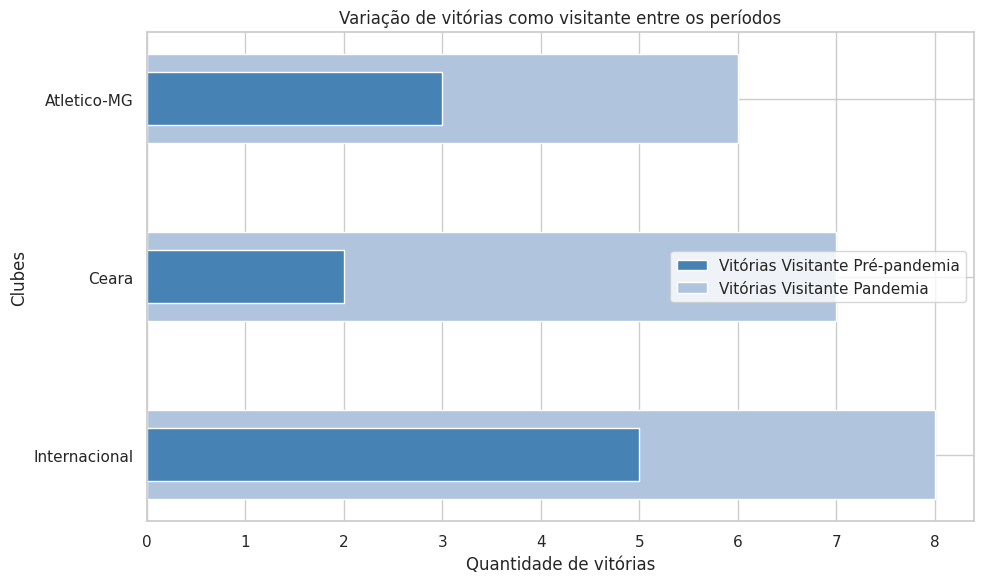

In [31]:
# Dados dos clubes com maior variação de vitórias como visitante
variacoes_vitorias_data = variacoes_vitorias_visitante.toPandas()

# Ordenar o DataFrame pela coluna 'Vitórias como Visitante'
variacoes_vitorias_data = variacoes_vitorias_data.sort_values(by='Vitórias como Visitante', ascending=False)

# Gráfico de variação de vitórias como visitante
plt.figure(figsize=(10, 6))
bar1 = plt.barh(variacoes_vitorias_data['Clube'], variacoes_vitorias_data['Vitórias como Visitante'], height=0.5, color='lightsteelblue', label='Vitórias Visitante Pandemia')
bar2 = plt.barh(variacoes_vitorias_data['Clube'], variacoes_vitorias_data['Vitórias como Visitante_Pre'], height=0.3, color='steelblue', label='Vitórias Visitante Pré-pandemia')

plt.xlabel('Quantidade de vitórias')
plt.ylabel('Clubes')
plt.title('Variação de vitórias como visitante entre os períodos')

# Obter a ordem dos itens na legenda
handles, labels = plt.gca().get_legend_handles_labels()

# Reverter a ordem dos itens na legenda
plt.legend(reversed(handles), reversed(labels), loc='right')

plt.tight_layout()
plt.show()

O Ceará apresentou uma variação bastante significativa, aumentando o número de vitórias como visitante de 2 para 7 entre os períodos. Durante a pandemia, a ausência de torcedores nos estádios pode ter impactado positivamente o desempenho do Ceará em jogos fora de casa, uma vez que a pressão e o apoio que os times mandantes recebem de seus torcedores foram totalmente reduzidos. Isso pode ter proporcionado mais tranquilidade aos jogadores visitantes e, consequentemente, um melhor rendimento em partidas longe de casa.

Mesma coisa Atlético-MG e Internacional, que tiveram uma variação positiva, passando de 3 vitórias como visitante no período pré-pandemia para 6 durante a pandemia e de 5 para 8 respectivamente. Assim como no caso do Ceará, a falta de torcedores nos estádios pode ter sido um fator que favoreceu o desempenho do Atlético-MG e Internacional em jogos como visitante. O ambiente menos hostil e a redução da pressão dos torcedores adversários podem ter contribuído para um melhor aproveitamento do time durante os jogos fora de casa.

Em geral, a falta de torcedores dos times mandantes durante a pandemia pode ter influenciado positivamente o desempenho dos clubes visitantes, como o Ceará, Atlético-MG e Internacional. O ambiente mais tranquilo e a redução da pressão dos torcedores adversários podem ter permitido que esses times se concentrassem mais em seu jogo e obtivessem melhores resultados como visitantes. Além disso, a falta de torcida nos estádios pode ter nivelado o campo de jogo, proporcionando uma competição mais equilibrada entre as equipes e favorecendo o desempenho dos visitantes.

# **17. Clubes que mais variaram na derrota como mandante**

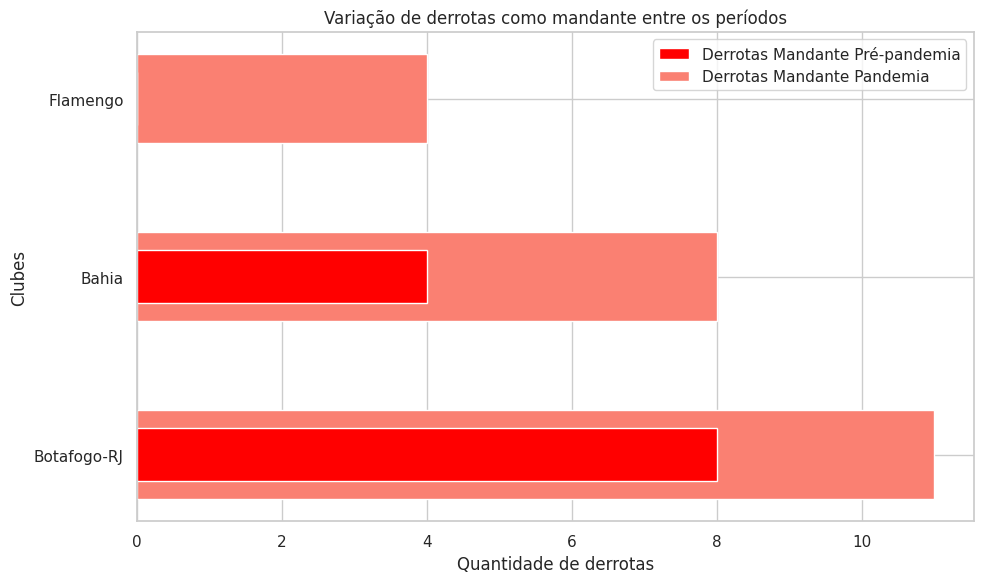

In [32]:

# Dados dos clubes com maior variação de derrotas como mandante
variacoes_derrotas_data = variacoes_derrotas_mandante.toPandas()

# Ordenar o DataFrame pela coluna 'Derrotas como Mandante'
variacoes_derrotas_data = variacoes_derrotas_data.sort_values(by='Derrotas como Mandante', ascending=False)

# Gráfico de variação de derrotas como mandante
plt.figure(figsize=(10, 6))
bar1 = plt.barh(variacoes_derrotas_data['Clube'], variacoes_derrotas_data['Derrotas como Mandante'], height=0.5, color='salmon', label='Derrotas Mandante Pandemia')
bar2 = plt.barh(variacoes_derrotas_data['Clube'], variacoes_derrotas_data['Derrotas como Mandante_Pre'], height=0.3, color='red', label='Derrotas Mandante Pré-pandemia')

plt.xlabel('Quantidade de derrotas')
plt.ylabel('Clubes')
plt.title('Variação de derrotas como mandante entre os períodos')

# Obter a ordem dos itens na legenda
handles, labels = plt.gca().get_legend_handles_labels()

# Reverter a ordem dos itens na legenda
plt.legend(reversed(handles), reversed(labels), loc='upper right')

plt.tight_layout()
plt.show()

O Flamengo teve uma variação significativa em suas derrotas como mandante, saindo de 0 derrotas no período pré-pandemia para 4 durante a pandemia. Embora o clube seja conhecido por ter uma grande torcida e um ambiente intimidador em seus jogos em casa, a falta de torcedores pode ter contribuído para um ambiente mais neutro. Sem o apoio dos torcedores, os adversários podem ter se sentido menos pressionados e o Flamengo pode ter enfrentado maior dificuldade em impor seu jogo em casa.

Bahia também apresentou uma variação considerável em suas derrotas como mandante, de 4 derrotas no período pré-pandemia para 8 durante a pandemia, seguido pelo Botafogo que passou de 8 para 11.

Com isso, assim como o impacto "positivo" para os clubes visitantes, também tivemos impactos negativos para os clubes mandantes. A falta de torcedores em mandos de campo durante a pandemia pode ter tido um impacto significativo nos resultados dos jogos em casa. Os clubes podem ter enfrentado desafios adicionais na busca por vitórias, já que o apoio e a pressão dos torcedores não estavam presentes nos estádios. A ausência de torcida pode ter nivelado o campo de jogo, proporcionando uma competição mais equilibrada e permitindo que os clubes visitantes tivessem um melhor desempenho em jogos fora de casa. Por outro lado, os times mandantes podem ter enfrentado dificuldades para se adaptar a esse novo cenário, resultando em um aumento no número de derrotas em seus domínios durante a pandemia.

# **18. Conclusão**

A pandemia do COVID-19 trouxe desafios sem precedentes para o futebol brasileiro, com a suspensão dos jogos e a retomada das partidas sem a presença de torcedores nos estádios. Nessa análise, busquei explorar o impacto dessa ausência de público no desempenho das equipes mandantes e visitantes, por meio da análise das estatísticas e da busca por insights sobre esse cenário e suas implicações para o jogo.

Para isso, utilizei dados do campeonato brasileiro em dois períodos distintos: antes (2019) e durante a pandemia (2020). Comparei as médias de vitórias do mandante, vitórias do visitante e empates entre esses dois períodos, a fim de identificar possíveis variações significativas.

É importante ressaltar que essas observações são baseadas nas médias e não refletem necessariamente o desempenho de todos os jogos individuais. Outros fatores, como a qualidade das equipes, estratégias de jogo, entre outros, também podem influenciar os resultados.

Em resumo, a ausência de torcedores durante a pandemia teve impactos significativos e ambíguos no desempenho das equipes no futebol brasileiro. Por um lado, a falta de apoio e pressão dos torcedores nos estádios nivelou o campo de jogo, proporcionando uma competição mais equilibrada e favorecendo o desempenho das equipes visitantes. Por outro lado, os times mandantes enfrentaram dificuldades para se adaptar a esse novo cenário, resultando em um aumento no número de derrotas em seus domínios durante a pandemia. Essa situação revelou a importância da torcida no contexto do esporte e destacou como sua ausência pode influenciar os resultados em campo, tornando o futebol durante a pandemia notavelmente diferente em relação ao período pré-pandemia.